In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
from random import random
import math
import csv

MAX_AUDIO_DURATION_MS = 4 * 1000
MAX_SAMPLE_COMPARISON_COUNT = 1000

apppath = os.path.expanduser('/Users/andrusasumets/projects/experiments/pacemaker/')
processedpath = os.path.join(apppath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
extensionpath = os.path.join(apppath, 'pacemaker WatchKit Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/downloads/')
metadatapath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/metadata/')
metadatacsvpath = os.path.join(apppath, 'processed/metadata.csv')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'
#handpickedfilenames = ['220177', '406270', '14031', '124998', '148979', '421133', '190096', '517118', '446582', '390764', '390759', '505135', '421136', '148996', '346700', '164678', '325262', '335930', '422971', '190113', '164643', '221364', '446600', '394181', '494494', '164584', '316578', '394180', '406735', '375964']

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [2]:
ids = [f for f in os.listdir(metadatapath)]
print(len(ids))

if not os.path.exists(metadatacsvpath):
    fieldnames = ['id', 'duration', 'downloads', 'rating', 'numratings', 'tags']
    rows = []

    for id in ids:
        with open(metadatapath + "/" + id) as file:
            try:
                id = int(id)
                line = file.readlines()[0]
                arguments = line.split('|')
                duration = int(arguments[0].split('duration:')[1])
                downloads = int(arguments[1].split('downloads:')[1])
                rating = int(arguments[2].split('rating:')[1])
                numratings = int(arguments[3].split('numratings:')[1])
                tags = arguments[4].split('tags:')[1]
                row = {
                    'id': id,
                    'duration': duration,
                    'downloads': downloads,
                    'rating': rating,
                    'numratings': numratings,
                    'tags': tags
                }
                rows.append(row)
            except Exception as e:
                print(e)

    with open(metadatacsvpath, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        
def read_csv(filename):
    with open(filename) as f:
        file_data = csv.reader(f)
        headers = next(file_data)
        return [dict(zip(headers, i)) for i in file_data] 

metadata = read_csv(metadatacsvpath)
print(len(metadata))

68455
68454


In [3]:
DOWNLOADS_THRESHOLD = 50
RATING_THRESHOLD = 95
MIN_NUMRATINGS = 10

scored = []
for sample in metadata:
    id = sample['id']
    duration = int(sample['duration'])
    downloads = int(sample['downloads'])
    rating = int(sample['rating'])
    numratings = int(sample['numratings'])
    tags = sample['tags']

    if len(tags) > 0 and downloads >= DOWNLOADS_THRESHOLD and rating >= RATING_THRESHOLD and numratings >= MIN_NUMRATINGS:
        row = [id, duration, downloads, rating, numratings, tags, rating * downloads]
        scored.append(row)

print(len(scored))

scored.sort(key=lambda x: int(x[6]))
scored.reverse()

print(scored[0])

278
['164472', 632, 12955, 95, 65, 'twig,snap,crack,branch,wood,break,tree,bough,undergrowth', 1230725]


In [4]:
samples = {}

for row in scored:
    id = row[0]
    samples[id] = {
        'duration': row[1],
        'downloads': row[2],
        'rating': row[3],
        'numratings': row[4],
        'tags': row[5],
        'score': row[6],
    }
    
print(samples[scored[0][0]])

{'duration': 632, 'downloads': 12955, 'rating': 95, 'numratings': 65, 'tags': 'twig,snap,crack,branch,wood,break,tree,bough,undergrowth', 'score': 1230725}


In [5]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
filtered = []

for filename in filenames:
    id = filename.split('__')[0]
    
    for row in scored:
        if row[0] == id:
            filtered.append(filename)
filenames = filtered
print('filtered filenames', len(filenames))

fileformats {'flac': 2888, 'wav': 46250, 'mp3': 2936, 'aiff': 19174, 'ogg': 679, 'm4a': 142, 'crdownload': 15, 'DS_Store': 1}
all_filenames: 72085
filtered filenames 278


In [6]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [7]:
def process(command):
    subprocess.check_output(command)

res = []
for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat
        
        if samples[fileid]['duration'] > MAX_AUDIO_DURATION_MS:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(filenames)
print(len(filenames))

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536753__egomassive__rat.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536753__egomassive__rat.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162464__kastenfrosch__message.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162464__kastenfrosch__message.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536759__egomassive__frog.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536759__egomassive__frog.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/a25gv79y.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_met

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59998__qubodup__weapon-swing-air-sound.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/172896__candlegravity__bell-bubbler-loop.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.47:measured_lra=0.0:measured_tp=-11.36:measured_thresh=-37.51:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/oa9dp2lc.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/172896__candlegravity__bell-bubbler-loop.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.47:measured_lra=0.0:measured_tp=-11.36:measured_thresh=-37.51:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/172896__candlegravity__bell-bubbler-loop.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/172896__candlegravity__bell-bubbler-loop.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/166605__qubodup__deadly-trap-with-spikes-and-sharp-sticks-for-video-games.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-9.54:measured_lra=0.0:measured_tp=0.5:measured_thresh=-22.52:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ab998drj.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/166605__qubodup__deadly-trap-with-spikes-and-sharp-sticks-for-video-games.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-9.54:measured_lra=0.0:measured_tp=0.5:measured_thresh=-22.52:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/166605__qubodup__deadly-trap-with-spikes-and-sharp-sticks-for-video-games.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/166605__qubodup__deadly-trap-with-spikes-and-sharp-sticks-for-video-games.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/414834__link-boy__hit-me.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/414834__link-boy__hit-me.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162467__kastenfrosch__gotitem.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162467__kastenfrosch__gotitem.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/240372__mariiao2__baby-cry.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/240372__mariiao2__baby-cry.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162476__kastenfrosch__gotitem.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162476__kastenfrosch__gotitem.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323498__spennnyyy__movie-cut-sound.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323498__spennnyyy__movie-cut-sound.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536769__egomassive__tire.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536769__egomassive__tire.ogg']' returned non-zero exit status 1.
['158140.m4a', '404743.m4a', '220174.m4a', '522168.m4a', '148975.m4a', '473578.m4a', '220181.m4a', '396448.m4a', '337847.m4a', '465610.m4a', '486081.m4a', '341253.m4a', '475347.m4a', '148974.m4a', '333403.m4a', '269592.m4a', '277054.m4a', '148972.m4a', '469608.m4a', '148953.m4a', '164678.m4a', '563465.m4a', '523088.m4a', '148957.m4a', '473575.m4a', '257929.m4a', '421128.m4a', '148979.m4a', '319617.m4a', '491706.m4a', '164595.m4a', '467794.m4a', '422975.m4a', '522095.m4a', '486082.m4a', '245951.m4a', '333398.m4a', '501102.m4a', '450833.m4a', '402183.m4a', '235264.m4a', '164472.m4a', '220172.m4a', '219480.m4a', '244450.m4a', '482663.m4a', '220175.m4a', '220169.m4a', '473582.m4a', '220171.m4a', '541998.m4a', '49941.m4a', '220184.m4a', '501104.

In [8]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    rightfilenames = sorted(rightfilenames, key=lambda x: random())
    
    #if leftid not in handpickedfilenames:
        #continue
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            duration = samples[leftid]['duration']
            out_distances[leftid].append([correlation, duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

0 / 62000


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)


1400 / 62000
2800 / 62000
3192


In [9]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [10]:
saved = []

for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue
        
    saved.append(leftid)
    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    command = ['cp', source, target]
    process(command)

print(len(saved))

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

57


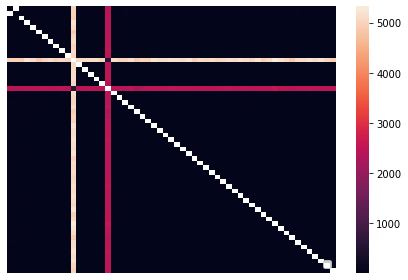

In [11]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(extensionpath + "heatmap.png", dpi=1000, facecolor="white")

In [12]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.22803053356037106


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0.5286179353745846


0.8230412304866835


0.8676779051928789


1.0599602903171705


5202.218373702419


5204.197120761448


5219.0935478596875


5219.317764628529


5325.725347609043
